# **Assignment 3.1: Group Comparison**

#### **Course:** ADS 509, Applied Large Language Models for Data Science

#### **Name:** Anna Shekikyan

#### **Date:** 09/22/2025

#### **GitHub:** https://github.com/AnahitShekikyan/ADS-509-Assignment-3.1-Group-Comparison

#### **ipynb:** https://colab.research.google.com/drive/1EIudyZtoDizfVaCL1ruPOl-MwD3cgcnN?usp=sharing

In [86]:
import os
import re
# ! pip install emoji
import emoji
import pandas as pd, csv

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
# ! pip install WordCloud 
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [100]:
# additional import
import nltk
import numpy as np
import random, numpy as np
random.seed(509); np.random.seed(509)

from matplotlib import pyplot as plt
from nltk.probability import FreqDist

In [88]:
# Place any addtional functions or constants you need here.

import nltk
nltk.download('stopwords')

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA :
    for em in emoji.EMOJI_DATA[country] :
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    num_tokens_total = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = (num_unique_tokens / num_tokens_total) if num_tokens_total > 0 else 0.0
    num_characters = sum(len(t) for t in tokens)

    if verbose:
        print(f"There are {num_tokens_total} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        # print the most common tokens
        top = Counter(tokens).most_common(num_tokens)
        print(f"Top {num_tokens} tokens: {top}")

    return(0)


def contains_emoji(s):

    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    sw_set = set(sw)
    cleaned = []
    for tok in tokens:
        # keep hashtags and single-character emojis
        if tok.startswith("#"):
            cleaned.append(tok)
        elif len(tok) == 1 and tok in all_language_emojis:
            cleaned.append(tok)
        elif tok not in sw_set:
            cleaned.append(tok)
    return cleaned


    return(tokens)

def remove_punctuation(text, punct_set=tw_punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    # modify the function to return tokens
    s = str(text).lower()
    # drop URLs and @mentions
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    # put spaces around emoji so they survive split
    s = "".join((f" {ch} " if ch in all_language_emojis else ch) for ch in s)
    # remove punctuation except '#'
    s = remove_punctuation(s, punct_set=tw_punct)
    # collapse whitespace and split to tokens
    tokens = whitespace_pattern.sub(" ", s).strip().split()

    text = tokens
    return(text)

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [101]:
data_location = r"C:\Users\annas\Downloads\M1 Assignment Data\M1 Results"

twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {
    "cher":  "cher_followers_data.txt",
    "robyn": "robynkonichiwa_followers_data.txt",
}

In [103]:
twitter_data = pd.read_csv(
    data_location + "/" + twitter_folder + artist_files['cher'],
    sep="\t",
    quoting=csv.QUOTE_NONE,
    engine="python"
)
twitter_data['artist'] = "cher"

In [104]:
twitter_data.head(2)

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher


In [105]:
twitter_data_2 = pd.read_csv(
    data_location + "/" + twitter_folder + artist_files['robyn'],
    sep="\t",
    quoting=csv.QUOTE_NONE,
    engine="python"
)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([twitter_data, twitter_data_2])
del twitter_data_2

In [106]:
# read in the lyrics here
# data_location and lyrics_folder are already set above
base_lyrics_dir = os.path.join(data_location, lyrics_folder)

def load_txt_folder(artist: str) -> pd.DataFrame:
    folder = os.path.join(base_lyrics_dir, artist)
    rows = []
    for fname in os.listdir(folder):
        if fname.lower().endswith(".txt"):
            path = os.path.join(folder, fname)
            with open(path, "r", encoding="utf-8", errors="replace") as f:
                text = f.read()
            # simple title from filename 
            title = fname[:-4]  # drop .txt
            if title.lower().startswith(artist.lower() + "_"):
                title = title[len(artist) + 1:]
            rows.append({
                "lyrics": text,
                "title": title,
                "artist": artist,
                "source_file": fname
            })
    return pd.DataFrame(rows)

lyrics_cher  = load_txt_folder("cher")
lyrics_robyn = load_txt_folder("robyn")

lyrics_data = pd.concat([lyrics_cher, lyrics_robyn], ignore_index=True)

# column for pipeline uses
LYR_COL = "lyrics"

print("Loaded lyrics_data:", lyrics_data.shape)
lyrics_data.head(3)

Loaded lyrics_data: (420, 4)


,lyrics,title,artist,source_file
0,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...",88degrees,cher,cher_88degrees.txt
1,"""A Different Kind Of Love Song""\n\n\n\nWhat if...",adifferentkindoflovesong,cher,cher_adifferentkindoflovesong.txt
2,"""After All""\n\n\n\nWell, here we are again\nI ...",afterall,cher,cher_afterall.txt


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [107]:
# tokenize + normalize lyrics
lyrics_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]  # remove_stop optional

lyrics_data = lyrics_data.copy()
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=lyrics_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

print(lyrics_data.groupby("artist")["title"].count())
lyrics_data.head(3)[["artist","title","num_tokens"]]

artist
cher     316
robyn    104
Name: title, dtype: int64


,artist,title,num_tokens
0,cher,88degrees,182
1,cher,adifferentkindoflovesong,137
2,cher,afterall,120


In [108]:
# drop missing bios first
twitter_data = twitter_data.dropna(subset=["description"]).reset_index(drop=True)

# tokenize + normalize twitter (keeps hashtags/emojis by design of tokenize)
twitter_pipeline = [str.lower, tokenize, remove_stop]

twitter_data = twitter_data.copy()
twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=twitter_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)

print(twitter_data.groupby("artist")["screen_name"].count())
twitter_data.head(3)[["artist","description","tokens"]]

artist
cher     2000921
robyn     190023
Name: screen_name, dtype: int64


,artist,description,tokens
0,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]"
1,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]"
2,cher,csu,[csu]


In [109]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [110]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1455509,cher,I meditate & are motivated to get mine!#NewBeg...,"[meditate, motivated, get, mine#newbeginnings,..."
392125,cher,19 | she/her 🏳️‍🌈,"[19, sheher, 🏳️‍🌈]"
1847983,cher,"Producer of the @NomadFamProject , creator/pro...","[producer, creatorproducerhost, ❤️s, #dogs, sw..."
412759,cher,21 Gay🌈💯 4:20 Friendly🍀,"[21, gay🌈💯, 420, friendly🍀]"
720814,cher,Odalys 🧡💫 222 🌌,"[odalys, 🧡💫, 222, 🌌]"
573942,cher,🇰🇷KPOPER🇰🇷 ♥️BTS♥️♥️ A.R.M.Y♥️ JUNG KOOK♥️V♥️ ...,"[🇰🇷kpoper🇰🇷, ♥️bts♥️♥️, army♥️, jung, kook♥️v♥..."
317669,cher,SF | Immunology/Virology | he/him 🏳️‍🌈|6’5”,"[sf, immunologyvirology, hehim, 🏳️‍🌈6’5”]"
1229496,cher,"Lifelong runner-18 Bostons,13 NYCs,2 Phila,1 M...","[lifelong, runner18, bostons13, nycs2, phila1,..."
1798858,cher,Sou casada gosto de rock e heavy metal adoro i...,"[sou, casada, gosto, de, rock, e, heavy, metal..."
599717,cher,Mom of 3 beautiful children DJ Nicholas and Ha...,"[mom, 3, beautiful, children, dj, nicholas, ha..."


With the data processed, we can now start work on the assignment questions. 

`Q:` What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

`A:` **Areas for improvement:** handling mixed tokens (split #artist🎤 → #artist, 🎤), standardizing hyphenation (“hype-girl” → hype, girl or keep as one), and optionally segmenting camelCase hashtags (#WeAllSleepAlone → we, all, sleep, alone).

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 

In [111]:
# pipeline for lyrics
lyrics_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# split by artist
cher_lyrics  = lyrics_data.loc[lyrics_data["artist"]=="cher",  LYR_COL].dropna()
robyn_lyrics = lyrics_data.loc[lyrics_data["artist"]=="robyn", LYR_COL].dropna()

# tokenize per song (doc)
cher_docs  = [prepare(t, lyrics_pipeline) for t in cher_lyrics]
robyn_docs = [prepare(t, lyrics_pipeline) for t in robyn_lyrics]

# flatten to corpus level
cher_all  = [tok for doc in cher_docs  for tok in doc]
robyn_all = [tok for doc in robyn_docs for tok in doc]

print("cher — lyrics")
descriptive_stats(cher_all, num_tokens=15, verbose=True)

print("\nrobyn — lyrics")
descriptive_stats(robyn_all, num_tokens=15, verbose=True)

# compact comparison table
import numpy as np, pandas as pd
def summarize(docs):
    toks = [tok for d in docs for tok in d]
    types = set(toks)
    lens = [len(d) for d in docs]
    return pd.Series({
        "songs": len(docs),
        "total_tokens": len(toks),
        "unique_types": len(types),
        "TTR": (len(types) / (len(toks) or 1)),
        "tokens_per_song_mean": float(np.mean(lens) if lens else 0.0),
        "tokens_per_song_median": float(np.median(lens) if lens else 0.0),
    })

comparison = pd.concat(
    {"cher": summarize(cher_docs), "robyn": summarize(robyn_docs)},
    axis=1
)
comparison

cher — lyrics
There are 35916 tokens in the data.
There are 3703 unique tokens in the data.
There are 172634 characters in the data.
The lexical diversity is 0.103 in the data.
Top 15 tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333), ('time', 319), ('baby', 319), ('see', 308), ('oh', 306), ('one', 282), ('go', 274), ('like', 271), ('come', 270), ('take', 263), ('heart', 260)]

robyn — lyrics
There are 15227 tokens in the data.
There are 2156 unique tokens in the data.
There are 73787 characters in the data.
The lexical diversity is 0.142 in the data.
Top 15 tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251), ('like', 232), ('baby', 222), ('youre', 169), ('never', 155), ('dance', 150), ('beat', 146), ('get', 143), ('killing', 136), ('gonna', 126), ('right', 125)]


,cher,robyn
songs,316.000000,104.000000
total_tokens,35916.000000,15227.000000
unique_types,3703.000000,2156.000000
TTR,0.103102,0.141591
tokens_per_song_mean,113.658228,146.413462
tokens_per_song_median,110.000000,137.000000


`Q:` What observations do you make about these data? 

`A:` Cher’s corpus is larger (316 songs, 35.9k tokens) but shows lower lexical diversity (TTR≈0.103), likely due to repetition across many tracks. Robyn’s smaller set (104 songs, 15.2k tokens) has higher diversity (TTR≈0.142) and longer songs on average (≈146 vs. ≈114 tokens). Top words suggest Cher leans toward romance/ballad vocabulary (“love,” “heart”), while Robyn mixes pop romance with dance/club language (“dance,” “beat”).

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [112]:
# Find tokens uniquely related to a corpus via concentration ratios

# flatten twitter tokens
flat_cher_tw = [tok for tokens_list in twitter_data.loc[twitter_data["artist"]=="cher", "tokens"].dropna() for tok in tokens_list]
flat_robyn_tw = [tok for tokens_list in twitter_data.loc[twitter_data["artist"]=="robyn", "tokens"].dropna() for tok in tokens_list]


# build corpora
corpora = {
    "cher_lyrics":  cher_all,
    "robyn_lyrics": robyn_all,
    "cher_twitter": flat_cher_tw,
    "robyn_twitter": flat_robyn_tw,
}

# counters and totals
counters = {k: Counter(v) for k, v in corpora.items()}
totals   = {k: sum(cnt.values()) for k, cnt in counters.items()}

# global cutoff n (appears at least n times in ALL corpora)
n = 5  # adjust if needed
common_vocab = set.intersection(*[
    {tok for tok, c in cnt.items() if c >= n}
    for cnt in counters.values()
])

# helper to compute top-k distinctive tokens for one corpus
def top_distinctive_for(target_name, topk=10):
    target_cnt = counters[target_name]
    target_tot = totals[target_name]

    # aggregate "other corpora"
    other_names = [k for k in counters if k != target_name]
    other_cnt_sum = Counter()
    other_tot_sum = 0
    for name in other_names:
        other_cnt_sum.update(counters[name])
        other_tot_sum += totals[name]

    rows = []
    for tok in common_vocab:
        c_i = target_cnt.get(tok, 0)
        c_o = other_cnt_sum.get(tok, 0)
        conc_i = c_i / target_tot if target_tot else 0.0
        conc_o = c_o / other_tot_sum if other_tot_sum else 0.0
        if conc_o == 0:
            # skip if totally absent elsewhere after cutoff 
            continue
        ratio = conc_i / conc_o
        rows.append((tok, c_i, conc_i, conc_o, ratio))

    df = pd.DataFrame(rows, columns=["token", "count_in_corpus", "conc_in_corpus", "conc_in_others", "ratio"])
    df = df.sort_values("ratio", ascending=False).head(topk).reset_index(drop=True)
    return df

# top-10 for each corpus
print("cher — Lyrics"); display(top_cher_lyrics)
print("robyn — Lyrics"); display(top_robyn_lyrics)
print("cher — Twitter"); display(top_cher_twitter)
print("robyn — Twitter"); display(top_robyn_twitter)

cher — Lyrics


,token,count_in_corpus,conc_in_corpus,conc_in_others,ratio
0,ooh,60,0.001671,0.000008,206.462256
1,chorus,60,0.001671,0.000011,158.906343
2,knock,36,0.001002,0.000015,68.709301
3,tonight,61,0.001698,0.000029,59.537787
4,ohh,12,0.000334,0.000007,47.538368
5,ooo,6,0.000167,0.000004,45.621499
6,tears,57,0.001587,0.000036,43.621855
7,gonna,222,0.006181,0.000218,28.369671
8,deny,8,0.000223,0.000008,27.132210
9,gotta,108,0.003007,0.000111,27.081698


robyn — Lyrics


,token,count_in_corpus,conc_in_corpus,conc_in_others,ratio
0,chorus,57,0.003743,0.000011,350.598642
1,ooo,6,0.000394,0.000004,107.739141
2,ohh,11,0.000722,0.000007,102.052909
3,beat,146,0.009588,0.000107,89.852101
4,88,14,0.000919,0.000011,87.563272
5,ooh,13,0.000854,0.000011,78.657380
6,deny,9,0.000591,0.000008,72.606813
7,itll,13,0.000854,0.000013,66.695659
8,crash,9,0.000591,0.000010,57.255658
9,alright,30,0.001970,0.000038,51.383283


cher — Twitter


,token,count_in_corpus,conc_in_corpus,conc_in_others,ratio
0,god,23143,0.001497,0.000571,2.621423
1,proud,30972,0.002004,0.000810,2.474702
2,faith,3243,0.000210,0.000095,2.214296
3,friend,16328,0.001056,0.000486,2.174973
4,woman,12523,0.000810,0.000379,2.137653
5,truth,7228,0.000468,0.000230,2.033824
6,stand,4773,0.000309,0.000161,1.917829
7,boys,8677,0.000561,0.000315,1.779867
8,two,15062,0.000974,0.000557,1.750766
9,mama,5797,0.000375,0.000215,1.741585


robyn — Twitter


,token,count_in_corpus,conc_in_corpus,conc_in_others,ratio
0,till,1294,0.000887,0.000128,6.944026
1,til,370,0.000254,0.000060,4.245244
2,sound,560,0.000384,0.000142,2.697551
3,men,944,0.000647,0.000255,2.536746
4,spinning,48,0.000033,0.000014,2.299688
5,music,14860,0.010191,0.005598,1.820559
6,88,26,0.000018,0.000011,1.665889
7,head,872,0.000598,0.000360,1.660634
8,dance,1555,0.001066,0.000656,1.625781
9,crash,24,0.000016,0.000010,1.595409


`Q:` What are some observations about the top tokens? Do you notice any interesting items on the list? 

`A:` Cher’s lyric-unique tokens skew toward interjections and section markers—“ooh,” “ohh,” “ooo,” and especially “chorus”—plus emotive/action words like “tonight,” “tears,” “gonna,” and “gotta,” which fits a pop-ballad, verse/chorus style. Robyn’s lyric-unique list leans club/pop: “beat,” “crash,” “alright,” with “88” pointing to a specific track/era and normalized contractions like “itll.”

On Twitter, Cher’s followers emphasize identity/values (“god,” “proud,” “faith,” “friend,” “woman,” “truth,” “mama”), while Robyn’s emphasize music/nightlife vocabulary (“music,” “dance,” “sound,” “spinning,” “head”) and timing variants (“till/til”). The frequent “chorus” token likely comes from transcription headers and could be filtered if cleaner semantic signals are desired.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.

In [113]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

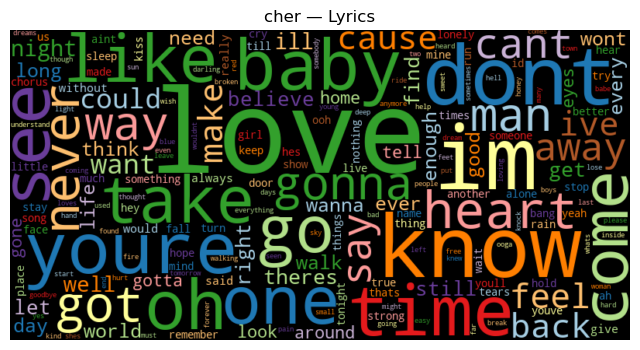

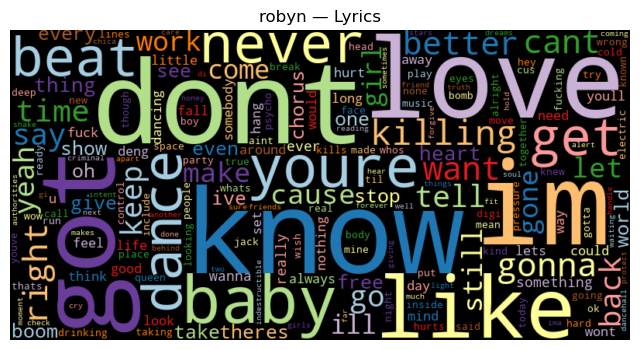

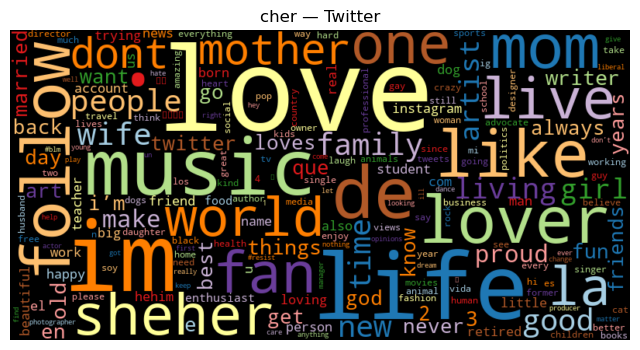

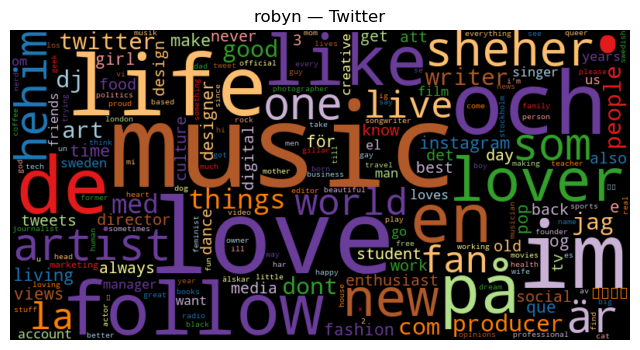

In [84]:
# word clouds for all four corpora, frequencies 
cher_lyrics_freq  = count_words(lyrics_data[lyrics_data["artist"]=="cher"],  column="tokens", min_freq=2)
robyn_lyrics_freq = count_words(lyrics_data[lyrics_data["artist"]=="robyn"], column="tokens", min_freq=2)

cher_tw_freq  = count_words(twitter_data[twitter_data["artist"]=="cher"],  column="tokens", min_freq=2)
robyn_tw_freq = count_words(twitter_data[twitter_data["artist"]=="robyn"], column="tokens", min_freq=2)

# word clouds
plt.figure(figsize=(8,6)); wordcloud(cher_lyrics_freq["freq"],  title="cher — lyrics")
plt.figure(figsize=(8,6)); wordcloud(robyn_lyrics_freq["freq"], title="robyn — lyrics")
plt.figure(figsize=(8,6)); wordcloud(cher_tw_freq["freq"],      title="cher — twitter")
plt.figure(figsize=(8,6)); wordcloud(robyn_tw_freq["freq"],     title="robyn — twitter")
plt.show()

`Q:` What observations do you have about these (relatively straightforward) wordclouds? 

`A:` The lyric clouds are classic pop: Cher leans into romance/ballad words (“love,” “heart,” “time,” “baby”), while Robyn mixes that with clear dance-club terms (“dance,” “beat,” “boom,” “killing”). The Twitter clouds center on bio staples (“music,” “love,” “life,” “follow”) plus identity tags (“sheher,” “hehim”), with language hints—Spanish (“de,” “la”) around Cher and Swedish (“och,” “på,” “är,” “jag”) around Robyn. Normalization shows up as “im/dont/youre,” but overall the visuals match the earlier story: Cher = classic pop/romance; Robyn = pop with a club edge.